# ZigZag Classification MNIST

In this notebook we will recreate the results of the MNIST notebook shown in the [official repo](https://github.com/cvlab-epfl/zigzag/blob/main/exps/notebooks/mnist_classification.ipynb). In particular, the evaluation scheme and code is the same as their notebook.

ZigZag was proposed by [Durasov et al 2024](https://openreview.net/forum?id=QSvb6jBXML).

## Imports

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from lightning import LightningDataModule, Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.uq_methods import ZigZagClassification
from lightning_uq_box.viz_utils import plot_training_metrics

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

In [2]:
seed_everything(0)

Seed set to 0


0

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

The following creates a quick Datamodule for the MNIST and MNIST Fashion Dataset so that we can easily train and evaluate our model. The MNIST Fashion dataset can be used as OOD evaluation.

In [4]:
def collate_fn(batch):
    """Colate function for dataloader as dictionary."""
    images, targets = zip(*batch)
    images = torch.stack(images)
    targets = torch.tensor(targets)
    return {"input": images, "target": targets}


class MNISTDatamodule(LightningDataModule):
    def __init__(self, root: str, batch_size: int = 64, num_workers=0):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.root = root

    def setup(self, stage: str) -> None:
        """Setup data loader."""
        if stage in ["fit", "validate"]:
            mnist_train = torchvision.datasets.MNIST(
                self.root,
                train=True,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    ]
                ),
            )
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage in ["test"]:
            self.mnist_test = torchvision.datasets.MNIST(
                self.root,
                train=False,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    ]
                ),
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_val,
            batch_size=self.batch_size * 10,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_test,
            batch_size=self.batch_size * 10,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )


class MNISTFashionDatamodule(MNISTDatamodule):
    """MNIST Fashion Datamodule"""

    def setup(self, stage: str) -> None:
        """Setup data loader."""
        if stage in ["fit", "validate"]:
            mnist_train = torchvision.datasets.FashionMNIST(
                self.root,
                train=True,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    ]
                ),
            )
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage in ["test"]:
            self.mnist_test = torchvision.datasets.FashionMNIST(
                self.root,
                train=False,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    ]
                ),
            )

In [5]:
datamodule = MNISTDatamodule(root="./data", batch_size=64, num_workers=2)
datamodule.setup("fit")
datamodule.setup("test")

fashion_dm = MNISTFashionDatamodule(root="./data", batch_size=64, num_workers=2)
fashion_dm.setup("test")

### Example Training Samples

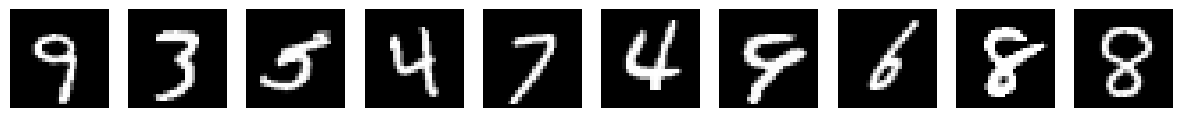

In [6]:
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
images, targets = batch["input"], batch["target"]

# Number of images you want to display
num_images = 10

# Create a figure and a row of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

# Plot each image on a separate subplot
for i in range(num_images):
    axes[i].imshow(images[i, 0], cmap="gray")
    axes[i].axis("off")  # Hide axis

plt.show()

## Model and Training

We use the same architecture they use in the notebook.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            2, 10, kernel_size=5
        )  # modified first layer, takes 2-channel image as input
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
zig_zag = ZigZagClassification(
    model=Net(),
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    loss_fn=nn.CrossEntropyLoss(),
    blank_const=-20,
)

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=5,
    accelerator="cpu",
    logger=logger,  # log training metrics for later evaluation
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(zig_zag, datamodule)

Missing logger folder: /tmp/tmp5hx49mih/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 24.6 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
24.6 K    Trainable params
0         Non-trainable params
24.6 K    Total params
0.099     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## Training Metrics

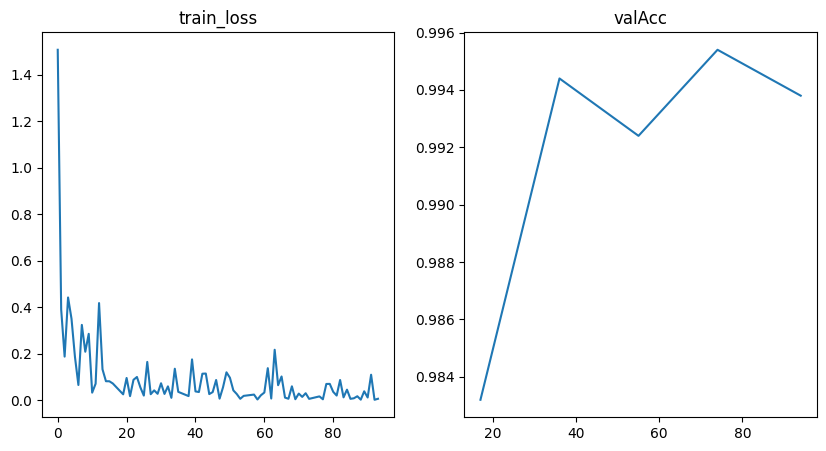

In [11]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "valAcc"]
)

## Prediction Evaluation

We evaluate predictions across in distribution and out of distribution samples, for the latter with the MNISTFashion Dataset. We use the same code as their notebook.

In [12]:
uncertainties = np.array([])
labels = np.array([])
target_acc = np.array([])

# IN Distribution
for batch in datamodule.test_dataloader():
    images, targs = batch["input"], batch["target"]
    preds = zig_zag.predict_step(images)
    uncertainties = np.concatenate([uncertainties, preds["pred_uct"]])
    labels = np.concatenate([labels, np.zeros_like(preds["pred_uct"])])
    target_acc = np.concatenate(
        [target_acc, (preds["pred"].argmax(1) == targs).numpy()]
    )

# Out of Distribution
for batch in fashion_dm.test_dataloader():
    images, targs = batch["input"], batch["target"]
    preds = zig_zag.predict_step(images)
    uncertainties = np.concatenate([uncertainties, preds["pred_uct"]])
    labels = np.concatenate([labels, np.ones_like(preds["pred_uct"])])
    target_acc = np.concatenate(
        [target_acc, (preds["pred"].argmax(1) == targs).numpy()]
    )

ROC AUC: 0.9849 
PR AUC: 0.9792


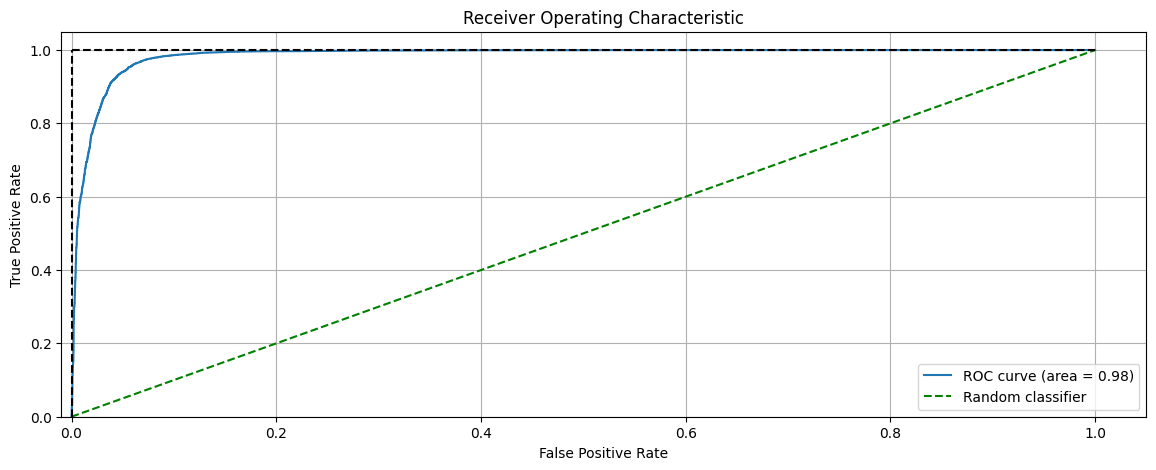

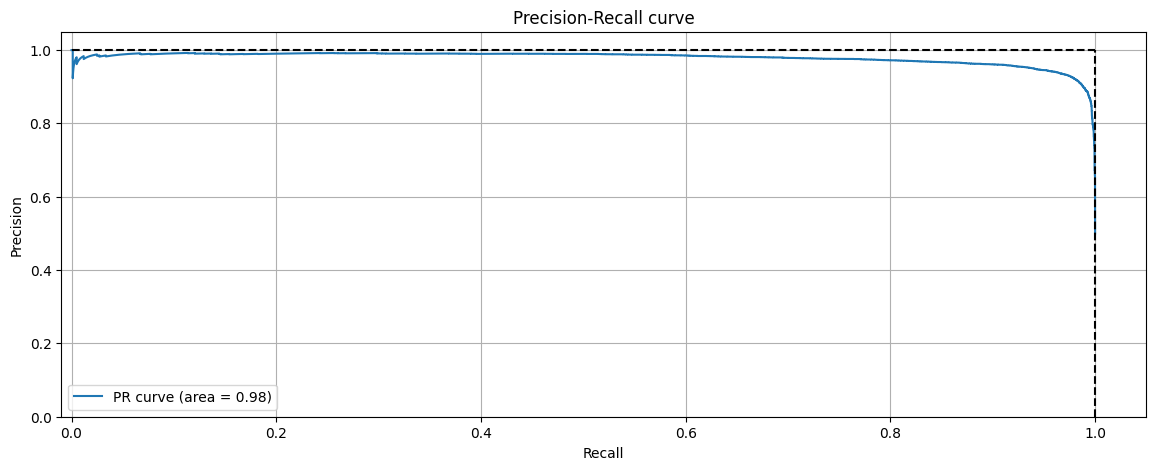

In [13]:
roc_auc = sklearn.metrics.roc_auc_score(labels, uncertainties)
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
    labels, uncertainties
)
pr_auc = sklearn.metrics.auc(recall, precision)

# evaluate ROC- and PR-AUC metrics, see https://arxiv.org/abs/1802.10501 for more details
print(f"ROC AUC: {roc_auc:.4f} ")
print(f"PR AUC: {pr_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(labels, uncertainties)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "g--", label="Random classifier")
plt.hlines(1, xmin=0, xmax=1, color="k", linestyle="--")
plt.vlines(0, ymin=0, ymax=1, color="k", linestyle="--")
plt.xlim([-0.01, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.grid()
plt.legend(loc="lower right")
plt.show()

# Plot PR curve
plt.figure()
plt.plot(recall, precision, label=f"PR curve (area = {pr_auc:.2f})")
plt.hlines(1, xmin=0, xmax=1, color="k", linestyle="--")
plt.vlines(1, ymin=0, ymax=1, color="k", linestyle="--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.xlim([-0.01, 1.05])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower left")
plt.show()

## Uncertainty Calibration Evaluation

For calibration evaluation, we also use their evaluation scheme, more specifically the rAULC metric. For more details, see https://arxiv.org/pdf/2107.00649.

In [14]:
uncertainties = np.array([])
labels = np.array([])
target_acc = np.array([])

# IN Distribution
for batch in datamodule.test_dataloader():
    images, targs = batch["input"], batch["target"]
    preds = zig_zag.predict_step(images)
    uncertainties = np.concatenate([uncertainties, preds["pred_uct"]])
    labels = np.concatenate([labels, np.zeros_like(preds["pred_uct"])])
    target_acc = np.concatenate(
        [target_acc, (preds["pred"].argmax(1) == targs).numpy()]
    )

0.021222563964778285 0.02053685294952734
0.9676895300497633


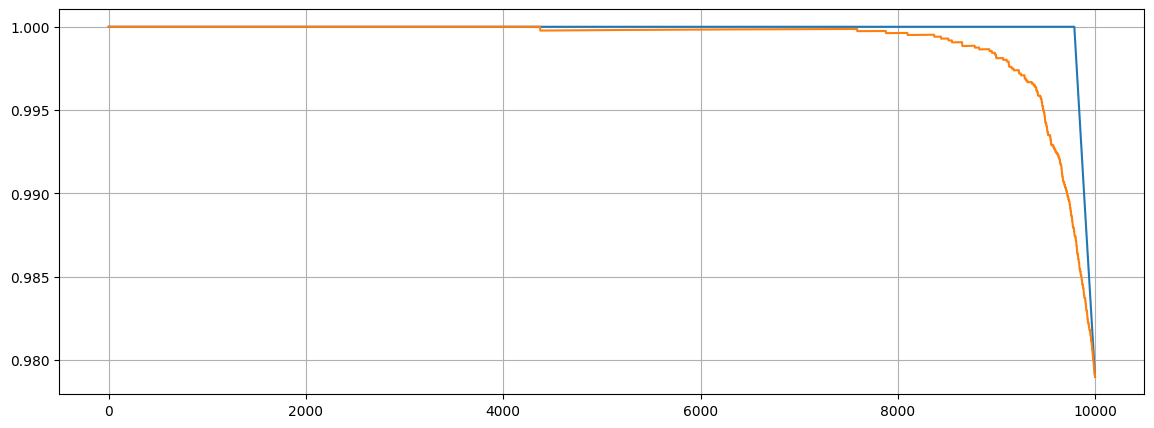

In [15]:
def AULC(accs, uncertainties):
    idxs = np.argsort(uncertainties)
    error_s = accs[idxs]

    mean_error = error_s.mean()
    error_csum = np.cumsum(error_s)

    Fs = error_csum / np.arange(1, len(error_s) + 1)
    s = 1 / len(Fs)
    return -1 + s * Fs.sum() / mean_error, Fs


def rAULC(uncertainties, accs):
    perf_aulc, Fsp = AULC(accs, -accs.astype("float"))
    curr_aulc, Fsc = AULC(accs, uncertainties)
    print(perf_aulc, curr_aulc)
    return curr_aulc / perf_aulc, Fsp, Fsc


res, r1, r2 = rAULC(uncertainties, target_acc)
print(res)

plt.plot(range(len(r1)), r1)
plt.plot(range(len(r1)), r2)
plt.grid()